In [1]:
import random
from typing import TypedDict

from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph

**Data Processing (Sequential)** 

State é a memória compartilhada e viva do seu workflow, é a linha de trabalho, onde cada ferramenta (`NODE`)
pega o que precisa e deixa seu resultado para a próxima.

In [2]:
class State(TypedDict):
    """Representa o estado compartilhado que flui através do grafo de processamento.

    Este dicionário atua como a memória central do workflow, onde cada nó
    pode ler informações de etapas anteriores e escrever seus resultados para
    etapas futuras.

    Attributes:
        input (int): O valor inicial fornecido ao grafo. Neste workflow,
            espera-se que seja um número (int ou float) para o cálculo inicial.
        output (int): O resultado da última operação executada. Cada nó
            atualiza este campo com seu próprio resultado, permitindo que o
            próximo nó o utilize.

    """

    input: int
    output: int

`NODE`: Os nós são as funções que realizam o trabalho de fato. Cada nó é uma "estação de trabalho" no seu fluxo

Análise Educativa: Observe o padrão fundamental em todos eles: uma função que recebe o **state** como argumento, executa sua tarefa e `retorna um dicionário apenas com as atualizações para o estado`. node_b, por exemplo, retorna {"output": output}, não o estado inteiro. O LangGraph cuida de fazer a "fusão" dessa atualização com o estado principal.



* `Start point: Start NODE`

In [3]:
def node_a(state: State) -> State:
    """Processa o estado inicial adicionando um valor aleatório.

    Esta função representa um "nó" em um grafo de processamento. Sua principal
    responsabilidade é pegar um valor numérico do estado de entrada,
    adicionar um deslocamento (offset) aleatório a ele e, em seguida,
    retornar um novo estado contendo o resultado.

    A função também imprime no console as etapas do seu cálculo para
    facilitar o rastreamento e a depuração do fluxo de dados, o que é
    uma prática muito útil ao trabalhar com sistemas complexos como LangGraph.

    Exemplo de uso:
        Se o estado de entrada for `State(input=10)` e o offset aleatório
        gerado for `5`, a função imprimirá os detalhes da operação e
        retornará `State(output=15)`.

    Args:
        state (State): Um objeto (provavelmente um dicionário ou TypedDict)
            que representa o estado atual do grafo. Espera-se que este
            objeto contenha uma chave 'input' com um valor numérico.

    Returns:
        State: Um novo objeto de estado contendo o resultado da operação.
            A chave 'output' conterá a soma do 'input' original com o
            offset aleatório gerado.

    """
    input_value = state["input"]
    offset = random.randint(1, 10)
    output = input_value + offset
    print(f"NODE A:\n ->input:{input_value}\n ->offset:{offset}\n ->output:{output}\n ")
    return State(output=output)

In [4]:
def node_b(state: State):
    input_value = state["output"]
    offset = random.randint(1, 10)
    output = input_value + offset
    print(f"NODE B:\n ->input:{input_value}\n ->offset:{offset}\n ->output:{output}\n ")
    return {"output": output}

O `workflow = StateGraph(...)` é a criação da "planta da fábrica". As arestas (`.add_edge()`) são as "esteiras rolantes" que conectam as estações de trabalho em uma sequência.

In [5]:
workflow = StateGraph(state_schema=State)

In [6]:
workflow.add_node(node_a)
workflow.add_node(node_b)

.add_edge é como o pathway (o caminho) entre os nós:

START *----> `NODE_a`---->(add_edge) *`NODE_b`---->END

O workflow começa na partida (`START`), então:

1. Adicionamos uma edge para o NODE_a.

2. O `NODE_a` executa seu processamento e entrega uma atualização com seus resultados (por exemplo: {'output': 8}).

3. O LangGraph recebe essa atualização e modifica o Estado Inteiro, que agora está atualizado e pronto para o próximo passo.

4. Adicionamos uma nova edge para ligar ao `NODE_b`.

5. O `NODE_b` recebe o Estado Inteiro já atualizado pelo passo anterior, faz seu trabalho e entrega sua própria atualização.

6. O LangGraph atualiza o Estado novamente.

Finalmente, adicionamos uma edge ao final do workflow, END.

In [7]:
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

In [8]:
graph = workflow.compile()

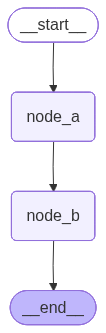

In [9]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
graph.invoke(
    input={
        "input": 1,
    },
)

NODE A:
 ->input:1
 ->offset:1
 ->output:2
 
NODE B:
 ->input:2
 ->offset:10
 ->output:12
 


{'input': 1, 'output': 12}

**Call LLMs**

In [11]:
from dotenv import load_dotenv

load_dotenv()

True

In [12]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

In [ ]:
class State(TypedDict):
    """Representa o estado do nosso grafo (workflow).

    Attributes:
        question: A pergunta a ser respondida.
        response: A resposta gerada pelo assistente.

    """

    question: str
    response: str

In [14]:
def model(state: State) -> dict[str, str]:
    """Invoca o modelo de linguagem para gerar uma resposta.

    Este nó do grafo recebe o estado atual, extrai a pergunta e utiliza
    o LLM (configurado como um especialista em Pokémon) para gerar uma
    resposta. A resposta é então adicionada ao estado.

    Args:
        state: O dicionário de estado atual, que deve conter a chave 'question'.

    Returns:
        Um dicionário contendo a chave 'response' com o conteúdo da
        resposta gerada pelo modelo.

    """
    question = state["question"]
    response = llm.invoke(
        [SystemMessage("You're a Pokémon specialist"), HumanMessage(question)]
    )

    return {"response": response.content}

In [15]:
workflow = StateGraph(State)

In [16]:
workflow.add_node("model", model)

In [17]:
workflow.add_edge(START, "model")
workflow.add_edge("model", END)

In [18]:
graph = workflow.compile()

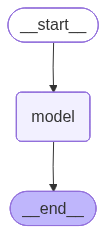

In [19]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
result = graph.invoke(
    input={"question": "What's the name of Ash's first pokémon?"},
)

In [21]:
result

{'question': "What's the name of Ash's first pokémon?",
 'response': "Ash's first Pokémon is Pikachu. He received Pikachu from Professor Oak at the beginning of his journey in the Pokémon anime series."}

### Um Agente com Múltiplos Passos
___

Vamos criar um agente que executa duas tarefas de LLM em sequência, com dois nós entre o START e o END.

Missão od Agente: Criar um "`Assistente de Perguntas`" que primeiro reformula a pergunta do usuário, para
ser mais clara e em seguida, responde a essa nova pergunta reformulada.


ARQUITETURA:
    >>> Estado(State) - pergunta original, pergunta reformulada e a resposta final.

In [24]:
from typing import TypedDict

from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph

# Configuração do LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)


# 1. Definição do Estado
class AgentState(TypedDict):
    """Estado compartilhado para o Assistente de Perguntas com processamento em
    duas etapas.

    Este TypedDict representa o estado que flui através do workflow do LangGraph,
    servindo como memória compartilhada entre os nós especializados. O assistente
    executa um processo de duas etapas para melhorar a qualidade das respostas:

    1. **Clarificação da Pergunta**: Um nó especializado recebe a pergunta
    original e a reformula para ser mais clara, específica e bem estruturada.

    2. **Resposta à Pergunta Clarificada**: Um segundo nó especializado recebe
       a pergunta reformulada e gera uma resposta precisa e detalhada.

    Esta arquitetura permite que cada LLM tenha um papel específico e otimizado,
    resultando em respostas de maior qualidade através da especialização das
    tarefas.

    Attributes:
        question (str): A pergunta original fornecida pelo usuário. Este é o
            ponto de entrada do workflow e permanece inalterado para referência.
        question_clarified (str): A versão reformulada e melhorada da pergunta
            original. É gerada pelo primeiro nó (especialista em clarificação)
            e serve como entrada para o segundo nó.
        answer (str): A resposta final gerada pelo segundo nó (especialista em
            resposta) baseada na pergunta clarificada. Este é o resultado final
            do workflow.

    Exemplo de fluxo:
        Input: question = "Como fazer café?"
        Node 1: question_clarified = "Quais são os passos detalhados para
                preparar café usando métodos tradicionais como coador de papel?"
        Node 2: answer = "Para preparar café usando coador de papel:
                1) Ferva água...

    Note:
        Este estado é mutável e é atualizado incrementalmente por cada nó do
        workflow. O LangGraph gerencia automaticamente a fusão das atualizações
        retornadas por cada nó com o estado compartilhado.

    """

    original_question: str
    question_clarified: str
    answer: str

In [25]:
# 2. Definição dos Nós
def reformulate_node(state: AgentState):  # type: ignore
    """Nó especializado para reformular e clarificar perguntas do usuário.

    Este nó é o primeiro estágio do workflow do Assistente de Perguntas.
    Sua função principal é receber uma pergunta original (potencialmente ambígua
    ou mal estruturada)e reformulá-la para ser mais clara, específica e
    otimizada para busca de informações.

    O nó utiliza um LLM especializado em clarificação de perguntas,
    seguindo um prompt estruturado que instrui o modelo a:
    - Tornar a pergunta mais clara e direta
    - Remover ambiguidades
    - Otimizar para busca de informações
    - Retornar apenas a pergunta reformulada, sem explicações adicionais

    Este processo de clarificação é fundamental para melhorar a qualidade das
    respostas finais, pois garante que o segundo nó (responsável pela resposta)
    trabalhe com uma pergunta bem estruturada e específica.

    Args:
        state (AgentState): O estado compartilhado do workflow. Deve conter a
        chave 'original_question' com a pergunta original do usuário.

    Returns:
        dict[str, str]: Um dicionário contendo apenas as atualizações do estado.
            Retorna {"question_clarified": reformulated_question} onde
            reformulated_question é a versão melhorada da pergunta original.

    Raises:
        KeyError: Se a chave 'original_question' não estiver presente no estado.
        AttributeError: Se o LLM não retornar um objeto com atributo 'content'.

    Example:
        >>> state = AgentState(original_question="Como fazer café?")
        >>> result = reformulate_node(state)
        >>> print(result)
        {'question_clarified': 'Quais são os passos detalhados para preparar café
         usando métodos tradicionais como coador de papel?'}

    Note:
        - Este nó segue o padrão LangGraph de retornar apenas atualizações
          parciais do estado, não o estado completo.
        - O LLM utilizado deve ser configurado com temperature baixa (0.0) para
          garantir consistência nas reformulações.
        - A função inclui logs detalhados para facilitar o debugging e
          monitoramento do workflow.

    """
    print("--- Entrando no NODE 1: Reformulação da Pergunta ---")
    original_question = state["original_question"]

    # * Prompt estruturado para instruir o LLM a reformular a pergunta
    prompt = [
        SystemMessage("""Sua tarefa é reformular a pergunta do usuário para que 
        ela seja mais clara, direta e otimizada para uma busca de informação.
        Retorne apenas a pergunta reformulada, sem explicações ou comentários.
        """),
        HumanMessage(original_question),
    ]

    # Invocar o LLM para reformular a pergunta
    response = llm.invoke(prompt)
    reformulated_question = response.content  # type: ignore
    print(f"Pergunta Reformulada: {reformulated_question}")

    # Retorna a ATUALIZAÇÃO do estado (padrão LangGraph)
    return {"question_clarified": reformulated_question}  # type: ignore

### Segundo NODE - Answer Node
___

In [26]:
def answer_node(state: AgentState):  # type: ignore
    """Nó especializado para gerar respostas educativas baseadas em perguntas
    clarificadas.

    Este nó é o segundo estágio do workflow do Assistente de Perguntas.
    Sua função principal é receber uma pergunta já reformulada e clarificada
    pelo primeiro nó e gerar uma resposta educativa, didática e detalhada.

    O nó atua como um tutor especializado em Python, utilizando um LLM
    configurado com um prompt específico que instrui o modelo a:
    - Responder de forma clara e didática
    - Incluir exemplos de código sempre que apropriado
    - Estruturar a resposta de maneira educativa
    - Fornecer explicações detalhadas e práticas

    Este processo de resposta especializada aproveita a qualidade da pergunta
    clarificada pelo primeiro nó, resultando em respostas mais precisas e úteis
    para o usuário final.

    Args:
        state (AgentState): O estado compartilhado do workflow. Deve conter a
        chave 'question_clarified' com a pergunta já reformulada pelo primeiro
        nó.

    Returns:
        dict[str, str]: Um dicionário contendo apenas as atualizações do estado.
            Retorna {"answer": answer} onde answer é a resposta educativa gerada
            pelo LLM especializado em tutoria de Python.

    Raises:
        KeyError: Se a chave 'question_clarified' não estiver presente no estado.
        AttributeError: Se o LLM não retornar um objeto com atributo 'content'.

    Example:
        >>> state = AgentState(question_clarified="Como implementar uma função
        ... que calcula o fatorial de um número em Python?")
        >>> result = answer_node(state)
        >>> print(result)
        {'answer': 'Para calcular o fatorial de um número em Python, você pode
         usar uma função recursiva...'}

    Note:
        - Este nó depende da saída do primeiro nó (reformulate_node) para
        funcionar corretamente.
        - O LLM é configurado com um prompt específico para tutoria de Python,
          garantindo respostas educativas e com exemplos práticos.
        - A função inclui logs para monitoramento, mostrando os primeiros 100
          caracteres da resposta gerada.
        - Segue o padrão LangGraph de retornar apenas atualizações parciais do
        estado.
        - A resposta final será armazenada no estado compartilhado e pode ser
          acessada por outros componentes do sistema.

    Workflow Integration:
        Este nó é tipicamente conectado após o reformulate_node no workflow,
        criando um pipeline de duas etapas:
        1. Clarificação da pergunta (reformulate_node)
        2. Geração da resposta educativa (answer_node)

    """
    print("--- ENTRANDO NO NÓ DE RESPOSTA ---")
    reformulated_question = state["question_clarified"]

    # Prompt estruturado para instruir o LLM a responder como tutor especializado
    prompt = [
        SystemMessage("""Você é um tutor expert em Python. Responda de forma clara, 
        didática e sempre que possível, com exemplos de código. Estruture sua 
        resposta de maneira educativa, explicando conceitos de forma progressiva 
        e fornecendo exemplos práticos quando apropriado."""),
        HumanMessage(reformulated_question),
    ]

    # * Invocar o LLM para gerar a resposta educativa
    response = llm.invoke(prompt)
    answer = response.content  # type: ignore
    print(f"Resposta Gerada: {answer[:100]}...")

    # * Retorna a ATUALIZAÇÃO final para o estado (padrão LangGraph)
    return {"answer": answer}  # type: ignore

### Construção do workflow
___

In [27]:
# * 3. Construção do Workflow
workflow = StateGraph(AgentState)

# Adiciona os nós
workflow.add_node("reformulate", reformulate_node)
workflow.add_node("answer", answer_node)

# Define as arestas (o caminho)
workflow.set_entry_point("reformulate")  # O ponto de partida é o nó de reformulação
workflow.add_edge(
    "reformulate", "answer"
)  # Depois de reformular, vá para o nó de resposta
workflow.add_edge("answer", END)  # Depois de responder, termine

# 4. Compilação e Visualização
graph = workflow.compile()

In [28]:
# Define as arestas (o caminho)
workflow.set_entry_point("reformulate")  # O ponto de partida é o nó de reformulação
workflow.add_edge(
    "reformulate", "answer"
)  # Depois de reformular, vá para o nó de resposta
workflow.add_edge("answer", END)  # Depois de responder, termine

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


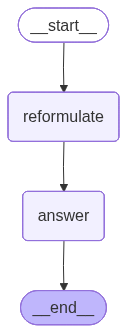

In [29]:
# 4. Compilação e Visualização
graph = workflow.compile()

# Visualizar o grafo para confirmar a estrutura
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
# 5. Execução
pergunta_usuario = "Como eu crio um decorator em python, preciso de alguma biblioteca?"
initial_state = {"original_question": pergunta_usuario}

final_state = graph.invoke(initial_state)

print("\n--- RESULTADO FINAL ---")
print(f"Pergunta Original: {final_state['original_question']}")
print(f"Pergunta Reformulada: {final_state['question_clarified']}")
print(f"Resposta: {final_state['answer']}")

--- Entrando no NODE 1: Reformulação da Pergunta ---
Pergunta Reformulada: Como criar um decorator em Python? É necessário usar alguma biblioteca?
--- ENTRANDO NO NÓ DE RESPOSTA ---
Resposta Gerada: Um decorator em Python é uma função que permite modificar o comportamento de outra função ou método....

--- RESULTADO FINAL ---
Pergunta Original: Como eu crio um decorator em python, preciso de alguma biblioteca?
Pergunta Reformulada: Como criar um decorator em Python? É necessário usar alguma biblioteca?
Resposta: Um decorator em Python é uma função que permite modificar o comportamento de outra função ou método. Decorators são uma maneira poderosa e flexível de adicionar funcionalidades a funções existentes sem modificar seu código diretamente. 

### Estrutura Básica de um Decorator

Um decorator é uma função que recebe outra função como argumento e retorna uma nova função que geralmente estende ou altera o comportamento da função original. Vamos ver como isso funciona passo a passo.

#